In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense,RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LSTM, Flatten
from keras.layers import Dropout
from keras.layers import RepeatVector, TimeDistributed

import tensorflow as tf
print(tf.__version__)
import time, sys
from IPython.display import clear_output

2.3.0


In [3]:
#### CNN BLOCK


# read the raw data
def read_raw_data(filename='Infosys.csv'):
    raw_data = pd.read_csv(filename)
    raw_data = raw_data.dropna()
    raw_data = raw_data.drop(['Adj Close'], axis=1)
    return raw_data

# process the raw data
def process_raw(raw_data, n_lag, n_seq):
    
    for i in range(1,n_lag+1):
        var_name = 'Shifted Close Price ' + str(i)
        raw_data[var_name] = raw_data['Close'].shift(i)
        
    for i in range(1,n_seq+1):
        var_name = 'Shifted Close Price ' + str(-i)
        raw_data[var_name] = raw_data['Close'].shift(-i)
        
    raw_data = raw_data.dropna()
    return raw_data

# processed_to_train_test
def train_test_reshape(raw_data, n_train_fraction=0.8):
    training_set = raw_data.values
    
    dates = training_set[:,0]
#     X_in = raw_data.values[:,1:11]
#     training_set_x_scaled = (X_in - X_in.min(axis=0)) / (X_in.max(axis=0) - X_in.min(axis=0))
#     X_out = raw_data.values[:,11:16]
#     training_set_y_scaled = (X_out - X_out.min(axis=0)) / (X_out.max(axis=0) - X_out.min(axis=0))
    
    n_train = int(len(training_set)*(n_train_fraction))
    train_sub_x = training_set[:n_train,1:11]
    train_sub_y = training_set[:n_train,11:16]
    training_dates = dates[:n_train]
    test_sub_x = training_set[n_train:,1:11]
    test_sub_y = training_set[n_train:,11:16]
    test_dates = dates[n_train:]

    x_train_cnn = train_sub_x.reshape(train_sub_x.shape[0],train_sub_x.shape[1],1)
    y_train_cnn = train_sub_y

    x_test_cnn = test_sub_x.reshape(test_sub_x.shape[0],test_sub_x.shape[1],1)
    y_test_cnn = test_sub_y
                  
    x_test_start_date = raw_data['Date'].values[n_train]
    x_test_end_date = raw_data['Date'].values[-1]
    
    return (x_train_cnn, y_train_cnn, x_test_cnn, y_test_cnn, test_dates, training_dates)
                  
# build and fit cnn model
def build_and_train(x_train, y_train, x_test, y_test, n_layers=3, n_filters=[32,64,128]):

    input_shape = x_train.shape[1]
    output_shape = y_train.shape[1]
    x_train = K.constant(x_train)
    y_train = K.constant(y_train)
    x_test = K.constant(x_test)
    y_test = K.constant(y_test)
    
    cnn_model = Sequential()
    cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(input_shape, 1)))
#     cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
#     cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(10, activation='relu'))
    cnn_model.add(Dense(units=output_shape))

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                    patience=5,
                                                    mode='min')
                  
    cnn_model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                      optimizer=tf.optimizers.Adam(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.Accuracy()])
    cnn_model.fit(x_train, y_train,
                  validation_data = (x_test, y_test),
                  epochs=10, batch_size=1)
                  
    return cnn_model
                  
# save model
def save_model(model, model_name='cnn_model'):
    model.save(model_name)
    return None

# precit and plot
def predict_and_plot(model, x_test, y_test_cnn, dates, raw_data):
    x_test = K.constant(x_test)
    y_pred = model.predict(x_test)
    plt.plot(y_pred[:,4], label='pred')
#     plt.plot(dates, y_test_cnn[:,4], label='actual')
    plt.legend()
    plt.show()
        

In [4]:
filename = 'Infosys.csv'
raw_data  = read_raw_data(filename)
raw_data = process_raw(raw_data, 5, 1)
# x_train_cnn, y_train_cnn, x_test_cnn, y_test_cnn, test_dates, training_dates = train_test_reshape(raw_data)
# cnn_model = build_and_train(x_train_cnn, y_train_cnn, x_test_cnn, y_test_cnn)
# save_model(cnn_model)
# predict_and_plot(cnn_model, x_test_cnn, y_test_cnn, test_dates, raw_data)

In [5]:
raw_data

,Date,Open,High,Low,Close,Volume,Shifted Close Price 1,Shifted Close Price 2,Shifted Close Price 3,Shifted Close Price 4,Shifted Close Price 5,Shifted Close Price -1
5,2000-01-17,95.312500,100.664001,91.562500,92.741402,18092928.0,95.128098,94.457802,102.167999,98.880898,107.478996,93.247299
6,2000-01-18,91.716400,95.070297,88.476601,93.247299,20290944.0,92.741402,95.128098,94.457802,102.167999,98.880898,100.702003
7,2000-01-19,98.015602,100.707001,97.031197,100.702003,19994752.0,93.247299,92.741402,95.128098,94.457802,102.167999,99.586304
8,2000-01-20,103.125000,105.866997,98.523399,99.586304,19778560.0,100.702003,93.247299,92.741402,95.128098,94.457802,104.845001
9,2000-01-21,100.780998,106.171997,97.679703,104.845001,20786048.0,99.586304,100.702003,93.247299,92.741402,95.128098,108.428001
...,...,...,...,...,...,...,...,...,...,...,...,...
5189,2020-09-29,1018.000000,1028.000000,1004.099976,1009.000000,8708463.0,1010.400024,1011.450012,975.400024,1019.750000,1007.500000,1008.250000
5190,2020-09-30,1009.000000,1023.950012,1005.000000,1008.250000,8048817.0,1009.000000,1010.400024,1011.450012,975.400024,1019.750000,1017.650024
5191,2020-10-01,1020.599976,1026.500000,1011.750000,1017.650024,5563358.0,1008.250000,1009.000000,1010.400024,1011.450012,975.400024,1048.699951
5192,2020-10-05,1018.049988,1054.900024,1018.049988,1048.699951,14212509.0,1017.650024,1008.250000,1009.000000,1010.400024,1011.450012,1055.750000


In [13]:
def prepare_train_data(raw_data, train_fraction=0.8):
    n_train = int(len(raw_data)*0.8)
    ## prepare lstm data unsaceld
    x_train_l = raw_data.values[:,6:11]
    x_train_sub = x_train_l[0:n_train]
    x_train_lstm = x_train_sub.reshape(x_train_sub.shape[0],1,x_train_sub.shape[1])

    x_test_sub = x_train_l[n_train:]
    x_test_lstm = x_test_sub.reshape(x_test_sub.shape[0],1,x_test_sub.shape[1])

    ## y train common
    y_train_lstm = raw_data.values[:,11].reshape(-1,1)[0:n_train]
    y_test_lstm = raw_data.values[:,11].reshape(-1,1)[n_train:]

    print(x_train_lstm.shape, y_train_lstm.shape, y_test_lstm.shape)
    
    x_train_lstm = np.asarray(x_train_lstm).astype(np.float32)
    y_train_lstm = np.asarray(y_train_lstm).astype(np.float32)
    x_test_lstm = np.asarray(x_test_lstm).astype(np.float32)
    y_test_lstm = np.asarray(y_test_lstm).astype(np.float32)

    return (x_train_lstm, y_train_lstm, x_test_lstm, y_test_lstm)

def lstm_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, batch_input_shape=(1, 1, 5),
                   return_sequences=True, activation='relu', recurrent_activation='hard_sigmoid'))
    lstm_model.add(LSTM(100, return_sequences=True, activation='relu', 
                   recurrent_activation='hard_sigmoid'))
    lstm_model.add(LSTM(50, activation='relu', recurrent_activation='hard_sigmoid'))
    lstm_model.add(Dense(16))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    lstm_model.compile(loss='mse', optimizer='adam')
    print(lstm_model.summary())
    return lstm_model

def train_lstm(lstm_model, n_epochs=10, n_nested_epochs=10, model_name='lstm_model'):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',patience=5, mode='min')
    for i in range(n_nested_epochs):
        lstm_model.fit(x_train_lstm, y_train_lstm, 
                       epochs=n_epochs, batch_size=1)
        lstm_model.reset_states()
    lstm_model.save(model_name)
    return lstm_model

def forecast(model, x, n_batch):
    fore = list()
    x = x.reshape(1, 1, x.shape[1])
    forecast = model.predict(x, batch_size=n_batch)
    x_new = np.array([x for x in forecast[0,:]])
    x_prev = x.reshape(5)
    x_next = np.append(x_prev[1:5],x_new)
    fore =np.append(fore, x_new)
    
    for i in range(4):
        x = x_next.reshape(1, 1, 5)
        forecast = model.predict(x, batch_size=n_batch)
        x_new = [x for x in forecast[0,:]]
        x_prev = x.reshape(5)
        x_next = np.append(x_prev[1:5],x_new)
        fore = np.append(fore, x_new)
    
    return fore

def forecast_lstm(lstm_model, x_test_lstm):
    forecasts = list()
    for i in range(len(x_test_lstm)):
        x= x_test_lstm[i,:]
        fore = forecast(lstm_model, x , 1)
        forecasts = np.append(forecasts, fore)
    forecasts = forecasts.reshape(len(x_test_lstm),5)
    return forecasts


In [14]:
x_train_lstm, y_train_lstm, x_test_lstm, y_test_lstm = prepare_train_data(raw_data)
lstm_model = lstm_model()
lstm_model = train_lstm(lstm_model)
y_pred = forecast_lstm(lstm_model, x_test_lstm)

(4096, 1, 5) (4096, 1) (1024, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, 1, 50)                11200     
_________________________________________________________________
lstm_4 (LSTM)                (1, 1, 100)               60400     
_________________________________________________________________
lstm_5 (LSTM)                (1, 50)                   30200     
_________________________________________________________________
dense_2 (Dense)              (1, 16)                   816       
_________________________________________________________________
dense_3 (Dense)              (1, 1)                    17        
Total params: 102,633
Trainable params: 102,633
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
4096/4096 [==============================] - 8s 2ms/step - loss: 

4096/4096 [==============================] - 7s 2ms/step - loss: 114.9609
Epoch 5/10
4096/4096 [==============================] - 8s 2ms/step - loss: 125.0989
Epoch 6/10
4096/4096 [==============================] - 7s 2ms/step - loss: 115.3121
Epoch 7/10
4096/4096 [==============================] - 7s 2ms/step - loss: 117.4003
Epoch 8/10
4096/4096 [==============================] - 7s 2ms/step - loss: 113.1800
Epoch 9/10
4096/4096 [==============================] - 8s 2ms/step - loss: 115.1040
Epoch 10/10
4096/4096 [==============================] - 7s 2ms/step - loss: 118.8806
Epoch 1/10
4096/4096 [==============================] - 7s 2ms/step - loss: 116.2149
Epoch 2/10
4096/4096 [==============================] - 8s 2ms/step - loss: 119.6888
Epoch 3/10
4096/4096 [==============================] - 8s 2ms/step - loss: 116.2318
Epoch 4/10
4096/4096 [==============================] - 8s 2ms/step - loss: 120.2535
Epoch 5/10
4096/4096 [==============================] - 7s 2ms/step - loss:

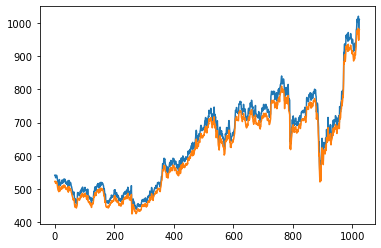

In [25]:
plt.plot(x_test_lstm[:,:,-1])
plt.plot(y_pred[:,4])

In [12]:
print(lstm_model)
def save_model(model, model_name='cnn_model'):
    model.save(model_name)
    return None

save_model(lstm_model, model_name='lstm_model')

<function lstm_model at 0x7f974ee4adc0>


AttributeError: 'function' object has no attribute 'save'

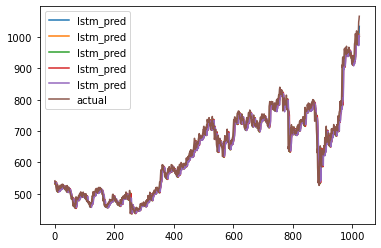

In [142]:
# plt.plot(y_pred_cnn, label='cnn_pred')
plt.plot(y_pred_lstm, label='lstm_pred')
# plt.plot(y_ensemble, label='ensemble')
plt.plot(y_actual, label='actual')
plt.legend()

[1.1350000e+03 1.1390000e+03 1.1153000e+03 1.1259000e+03 1.2902146e+07
 1.1275000e+03 1.1082500e+03 1.1370000e+03 1.1578000e+03 1.1321000e+03]
[[[1127.5  1108.25 1137.   1157.8  1132.1 ]]]


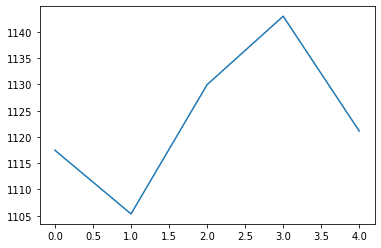

In [145]:
opens, high, low, close, volume, shift1, shift2, shift3, shift4, shift5 = \
    [1135.00,1139.00,1115.30,1125.90,12902146, 1127.50, 1108.25, 1137.00, 1157.80, 1132.10]
inputs = np.array([opens, high, low, close, volume, shift1, shift2, shift3, shift4, shift5])
print(inputs)
x_train_l = inputs[5:10]
x_train_l = x_train_l.reshape(1,1,x_train_l.shape[0])
x_train_l = np.asarray(x_train_l).astype(np.float32)
print(x_train_l)

def forecast_lstm(model, x, n_batch):
    fore = list()
    x = x.reshape(1, 1, x.shape[1])
    forecast = model.predict(x, batch_size=n_batch)
    x_new = np.array([x for x in forecast[0,:]])
    x_prev = x.reshape(5)
    x_next = np.append(x_prev[1:5],x_new)
    fore =np.append(fore, x_new)
    
    for i in range(4):
        x = x_next.reshape(1, 1, 5)
        forecast = model.predict(x, batch_size=n_batch)
        x_new = [x for x in forecast[0,:]]
        x_prev = x.reshape(5)
        x_next = np.append(x_prev[1:5],x_new)
        fore = np.append(fore, x_new)
        
    return fore

forecasts = list()
for i in range(len(x_train_l)):
    x= x_train_l[i,:]
    fore = forecast_lstm(lstm_model, x , 1)
    forecasts = np.append(forecasts, fore)
    
y_pred_l = (forecasts)
plt.plot(y_pred_l, label='lstm_pred')